In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,Conv1D,MaxPooling1D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
%matplotlib inline

In [2]:
import glob
import json
import pandas as pd
import gzip

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [3]:
dir_data = 'LDS8_DeThi_k270/Dataset/reviews_Clothing_Shoes_and_Jewelry_5.json.gz'

In [4]:
data = getDF(dir_data)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278677 entries, 0 to 278676
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      278677 non-null  object 
 1   asin            278677 non-null  object 
 2   reviewerName    278225 non-null  object 
 3   helpful         278677 non-null  object 
 4   reviewText      278677 non-null  object 
 5   overall         278677 non-null  float64
 6   summary         278677 non-null  object 
 7   unixReviewTime  278677 non-null  int64  
 8   reviewTime      278677 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 21.3+ MB


In [6]:
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,1394841600,"03 15, 2014"


In [7]:
data.tail()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
278672,A2DG63DN704LOI,B00KKXCJQU,ESlayd,"[0, 1]",I don't normally go ga-ga over a product very ...,5.0,These have literally changed the way I travel!,1403568000,"06 24, 2014"
278673,A1EVV74UQYVKRY,B00KKXCJQU,K. Groh,"[0, 0]",I've been traveling back and forth to England ...,5.0,Wonderful for Better Packing,1403740800,"06 26, 2014"
278674,A1UQBFCERIP7VJ,B00KKXCJQU,Margaret Picky,"[1, 1]",These are very nice packing cubes and the 18 x...,5.0,"Convenient, lightweight, and durable",1402185600,"06 8, 2014"
278675,A22CW0ZHY3NJH8,B00KKXCJQU,Noname,"[2, 2]",I am on vacation with my family of four and th...,5.0,Holds Up Well In Real World Test,1404691200,"07 7, 2014"
278676,A30VWT3R25QAVD,B00KKXCJQU,"THE-DEADLY-DOG ""Living and Loving Life.""","[0, 1]",When I signed up to receive a free set of Shac...,5.0,Don't Travel? Still Way too Useful for 'Averag...,1403481600,"06 23, 2014"


In [8]:
data.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [9]:
data['words'] = data['reviewText'].map(lambda x: len(x.split()))
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,words
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011",35
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013",61
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013",62
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",1398556800,"04 27, 2014",76
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,1394841600,"03 15, 2014",80


In [10]:
data['words'].describe()

count    278677.000000
mean         59.953046
std          61.289861
min           0.000000
25%          26.000000
50%          41.000000
75%          70.000000
max        3882.000000
Name: words, dtype: float64

In [11]:
data[['overall','words']].groupby("overall").mean("words")

,words
overall,
1.0,63.988295
2.0,65.800750
3.0,64.584552
4.0,65.105026
5.0,56.417434


/home/waflol/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of each overall')

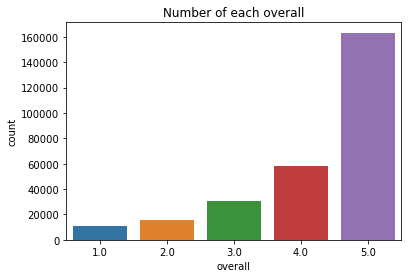

In [12]:
sns.countplot(data.overall)
plt.xlabel("overall")
plt.title("Number of each overall")

In [13]:
def split_overall(x):
    if x == 1. or x == 2. or x == 3.:
        return 0 #  'unsatisfied'
    else:
        return 1 # 'pleasure'

In [14]:
data['status'] = data['overall'].map(lambda x: split_overall(x))

/home/waflol/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of each status')

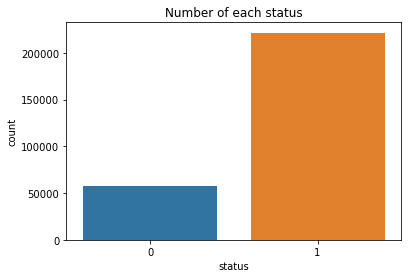

In [15]:
sns.countplot(data.status)
plt.xlabel("status")
plt.title("Number of each status")

<h3>Nhận xét</h3>
<li>Tập dữ liệu bị mất cân bằng ở cột target</li>
<li>Ở biểu đồ countplot của cột overral thì đánh giá 5 sao cao hơn hẳn so với cột còn lại</li>
<li>Do bị ảnh hưởng bới cột 5 sao ở trên nên trên bảng status, cột 1 (pleasure) cũng có số lượng hơn hẳn cột còn lại</li>

<h1>Split data</h1>

In [16]:
train,test = train_test_split(data[['reviewText','overall','status']],test_size=0.3,random_state=42,shuffle=True)

In [17]:
X_train,y1_train,y2_train = train.reviewText,train.overall.astype('object'),train.status

In [18]:
X_test,y1_test,y2_test = test.reviewText,test.overall.astype('object'),test.status

<h1>Process outputs data</h1>

In [19]:
y1_train = pd.get_dummies(y1_train)

In [20]:
y1_train.shape

(195073, 5)

In [21]:
y2_train = pd.get_dummies(y2_train,drop_first=True)

In [22]:
y2_train.shape

(195073, 1)

In [23]:
y1_train

,1.0,2.0,3.0,4.0,5.0
69234,0,0,0,1,0
79668,0,0,0,1,0
267519,0,1,0,0,0
105955,0,1,0,0,0
44011,0,0,0,0,1
...,...,...,...,...,...
119879,0,0,1,0,0
259178,0,0,0,0,1
131932,0,0,0,0,1
146867,0,0,1,0,0


In [24]:
y2_train

,1
69234,1
79668,1
267519,0
105955,0
44011,1
...,...
119879,0
259178,1
131932,1
146867,0


<h1>Process input data</h1>

In [25]:
max_words = 2000
max_len=300
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)


sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [26]:
print(sequences[:2])

[[24, 115, 18, 15, 79, 132, 6, 144, 32, 190, 26, 4, 137, 10, 7, 47, 28, 4, 139, 3, 251, 374, 2, 61, 1365, 69, 29, 321], [502, 257, 190, 6, 300, 15, 6, 275, 5, 80, 1, 1504, 87, 140, 55, 1, 76, 676, 798, 278, 6, 18, 3, 6, 275, 28, 6, 44, 107, 8, 12, 608]]


<h1>Build and Train model</h1>

In [27]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    x = Embedding(max_words,50,input_length=max_len)(inputs)
    layer_overall = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    layer_overall = MaxPooling1D(pool_size=2)(layer_overall)
    layer_overall = LSTM(100)(layer_overall)
    layer_overall = Dense(512,name='FC1_overall',activation='relu')(layer_overall)
    layer_overall = Dropout(0.3)(layer_overall)
    layer_overall = Dense(50,name='FC2_overall',activation='relu')(layer_overall)
    layer_overall = Dropout(0.3)(layer_overall)
    output_2 = Dense(5,activation='softmax',name='overall_output')(layer_overall)
    
    
    layer_status = LSTM(64)(x)
    layer_status= Dense(512,name='FC1_status',activation='relu')(layer_status)
    layer_status = Dropout(0.5)(layer_status)
    layer_status= Dense(32,name='FC2_status',activation='relu')(layer_status)
    layer_status = Dropout(0.5)(layer_status)
    output_1 = Dense(1,activation='sigmoid',name='status_output')(layer_status)
    
    return Model(inputs=inputs,outputs=[output_1,output_2])
    #return Model(inputs=inputs,outputs=[output_2])

In [28]:
model = RNN()

In [29]:
model.compile(optimizer='adam',
              loss={
                  'overall_output':'categorical_crossentropy',
                  'status_output':'binary_crossentropy'},
              metrics={'overall_output':'accuracy',
                       'status_output':'accuracy'})

In [30]:
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 50)      100000      ['inputs[0][0]']                 
                                                                                                  
 conv1d (Conv1D)                (None, 300, 64)      9664        ['embedding[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 150, 64)      0           ['conv1d[0][0]']                 
                                                                                              

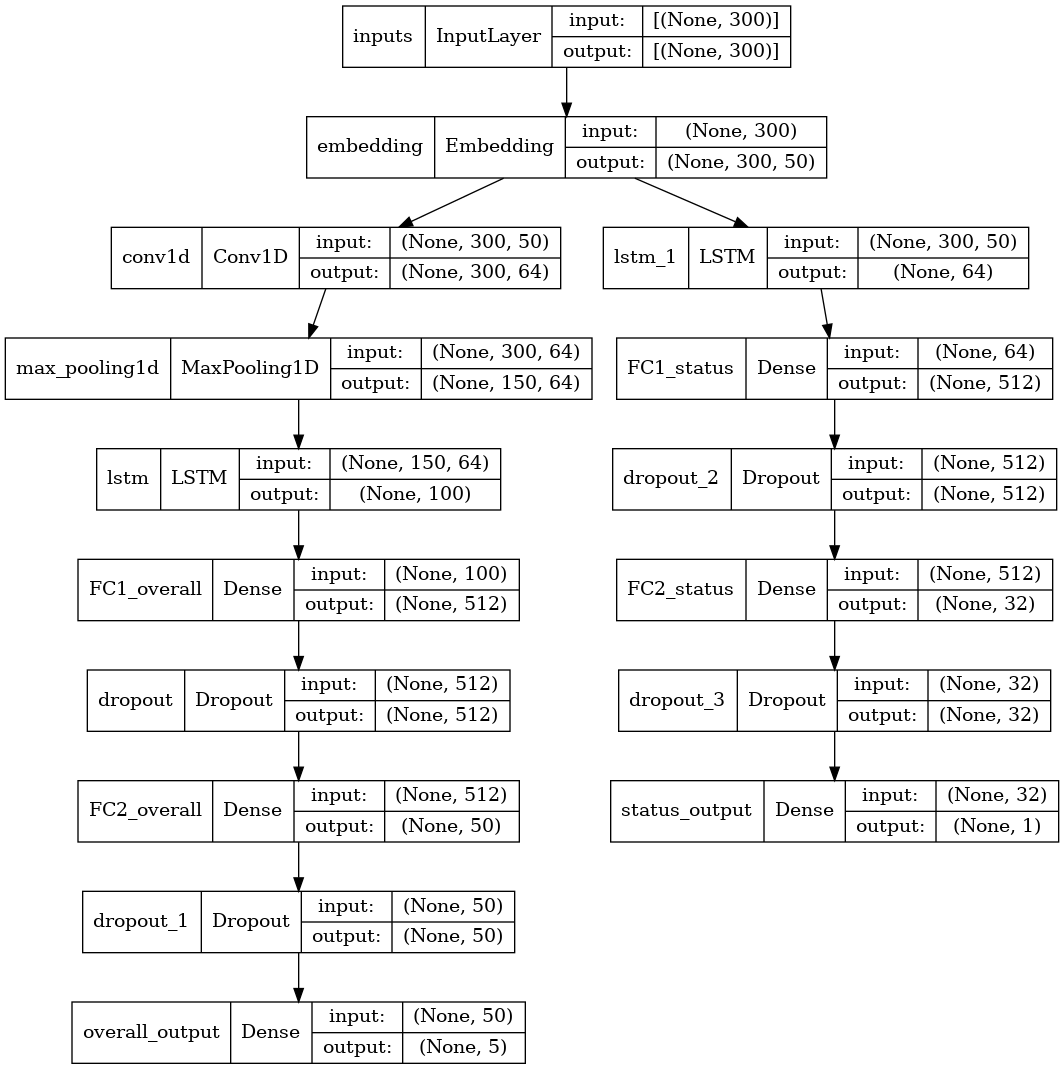

In [32]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='Ex6_RNN_NLP_LSTM.png', show_shapes=True)
Image(filename='Ex6_RNN_NLP_LSTM.png')

In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=30,restore_best_weights=True,mode='min',verbose=1)
learning_rate = ReduceLROnPlateau(verbose=1,factor=0.5,min_delta=0.000001,patience=30)

In [34]:
history = model.fit(x = sequences_matrix,y = {'overall_output':y1_train,'status_output':y2_train},
                    batch_size=128,epochs=500,validation_split=0.2,
                    callbacks=[early_stopping,learning_rate])

Epoch 1/500
1220/1220 [==============================] - 52s 40ms/step - loss: 1.2029 - status_output_loss: 0.3153 - overall_output_loss: 0.8876 - status_output_accuracy: 0.8649 - overall_output_accuracy: 0.6407 - val_loss: 1.0590 - val_status_output_loss: 0.2655 - val_overall_output_loss: 0.7935 - val_status_output_accuracy: 0.8888 - val_overall_output_accuracy: 0.6749 - lr: 0.0010
Epoch 2/500
1220/1220 [==============================] - 48s 39ms/step - loss: 1.0348 - status_output_loss: 0.2557 - overall_output_loss: 0.7791 - status_output_accuracy: 0.8951 - overall_output_accuracy: 0.6809 - val_loss: 1.0081 - val_status_output_loss: 0.2476 - val_overall_output_loss: 0.7605 - val_status_output_accuracy: 0.8998 - val_overall_output_accuracy: 0.6881 - lr: 0.0010
Epoch 3/500
1220/1220 [==============================] - 48s 39ms/step - loss: 0.9804 - status_output_loss: 0.2356 - overall_output_loss: 0.7448 - status_output_accuracy: 0.9043 - overall_output_accuracy: 0.6944 - val_loss: 0.98

1220/1220 [==============================] - 48s 39ms/step - loss: 0.5448 - status_output_loss: 0.1297 - overall_output_loss: 0.4151 - status_output_accuracy: 0.9447 - overall_output_accuracy: 0.8271 - val_loss: 1.4207 - val_status_output_loss: 0.3458 - val_overall_output_loss: 1.0749 - val_status_output_accuracy: 0.8964 - val_overall_output_accuracy: 0.6686 - lr: 0.0010
Epoch 23/500
1220/1220 [==============================] - 48s 39ms/step - loss: 0.5264 - status_output_loss: 0.1255 - overall_output_loss: 0.4009 - status_output_accuracy: 0.9471 - overall_output_accuracy: 0.8328 - val_loss: 1.7224 - val_status_output_loss: 0.3739 - val_overall_output_loss: 1.3485 - val_status_output_accuracy: 0.8952 - val_overall_output_accuracy: 0.6480 - lr: 0.0010
Epoch 24/500
1220/1220 [==============================] - 48s 39ms/step - loss: 0.5215 - status_output_loss: 0.1320 - overall_output_loss: 0.3895 - status_output_accuracy: 0.9450 - overall_output_accuracy: 0.8379 - val_loss: 1.6818 - val_s

<h1>Evaluation</h1>

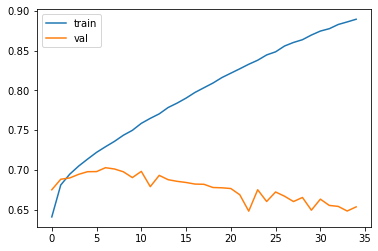

In [44]:
plt.plot(history.history['overall_output_accuracy'])
plt.plot(history.history['val_overall_output_accuracy'])
plt.legend(['train','val'])

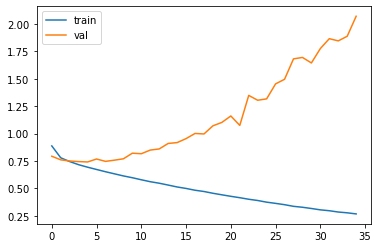

In [45]:
plt.plot(history.history['overall_output_loss'])
plt.plot(history.history['val_overall_output_loss'])
plt.legend(['train','val'])

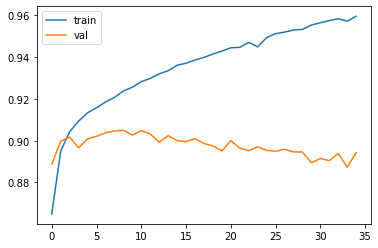

In [46]:
plt.plot(history.history['status_output_accuracy'])
plt.plot(history.history['val_status_output_accuracy'])
plt.legend(['train','val'])

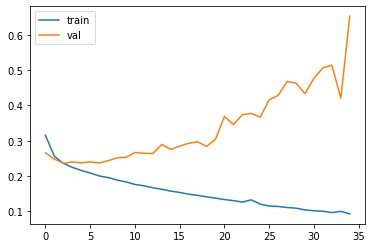

In [47]:
plt.plot(history.history['status_output_loss'])
plt.plot(history.history['val_status_output_loss'])
plt.legend(['train','val'])

In [48]:
sequences_test = tok.texts_to_sequences(X_test)
sequences_matrix_test = sequence.pad_sequences(sequences_test,maxlen=max_len)

In [49]:
y1_test = pd.get_dummies(y1_test)
y2_test = pd.get_dummies(y2_test,drop_first=True)

In [50]:
scores = model.evaluate(sequences_matrix_test,{'overall_output':y1_test,'status_output':y2_test})
scores

2613/2613 [==============================] - 20s 8ms/step - loss: 0.9720 - status_output_loss: 0.2349 - overall_output_loss: 0.7370 - status_output_accuracy: 0.9021 - overall_output_accuracy: 0.6968


[0.9719582796096802,
 0.2349136918783188,
 0.7370453476905823,
 0.9020501375198364,
 0.6967848539352417]

<h1>Nhận xét:</h1>
    <li>Model bị overfiting bắt đầu từ epoch thứ 3</li>

In [52]:
!pwd

/home/waflol/LDS8_K270_ONLINE_LeNguyenHungAnh/LDS8_K270_LeNguyenHungAnh_Cuoi_ky


In [56]:
model.save('checkpoint/Ex6/ex6Model.h5')